In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
# import the necessary packages
from skimage.segmentation import clear_border
import pytesseract
from anrp import PyImageSearchANPR
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imutils
import cv2

In [3]:
# Show image
def show_image(image):
    plt.imshow(image)
    plt.show()

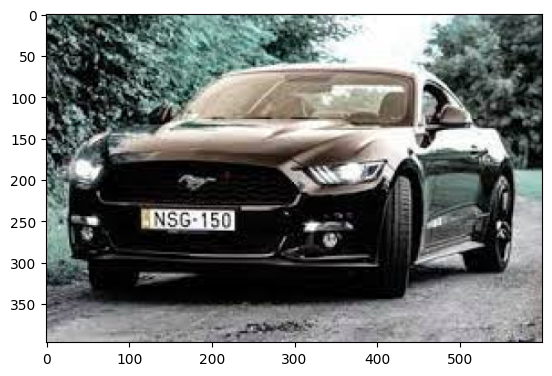

In [25]:
imagePath = 'example_images/images.jfif'
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)

plt.imshow(image)
plt.show()


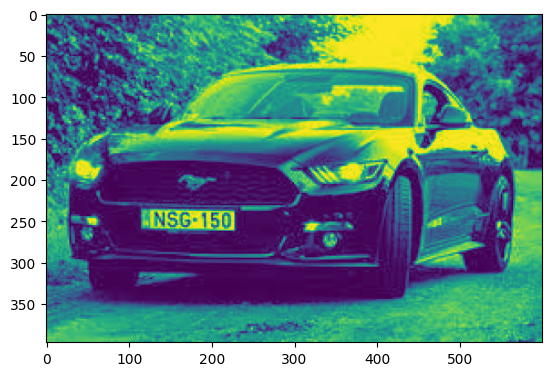

In [26]:
# initialize the license plate text
lpText = None
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.show()

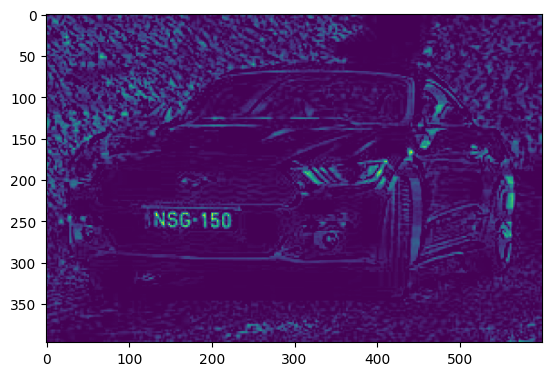

In [27]:
# Locate License plate Candidates

# perform a blackhat morphological operation that will allow
# us to reveal dark regions (i.e., text) on light backgrounds
# (i.e., the license plate itself)
rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)

show_image(blackhat)

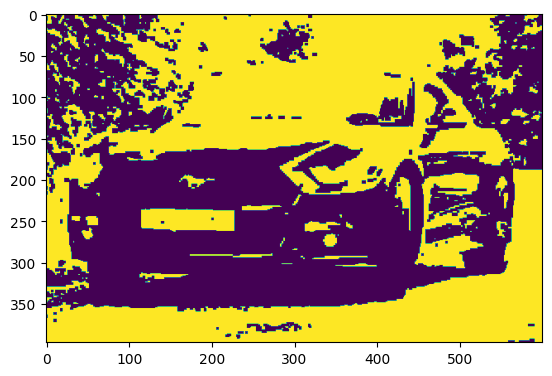

In [28]:
# next, find regions in the image that are light
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
light = cv2.threshold(light, 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
show_image(light)

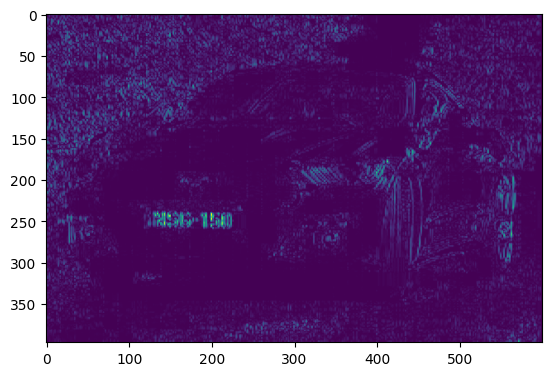

In [29]:
# compute the Scharr gradient representation of the blackhat
# image in the x-direction and then scale the result back to
# the range [0, 255]
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
    dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
gradX = gradX.astype("uint8")
show_image(gradX)

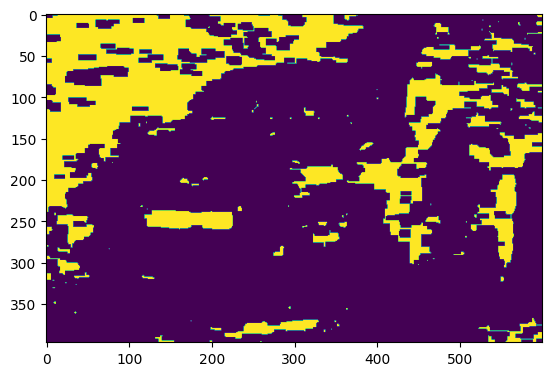

In [30]:
# blur the gradient representation, applying a closing
# operation, and threshold the image using Otsu's method
gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
thresh = cv2.threshold(gradX, 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
show_image(thresh)

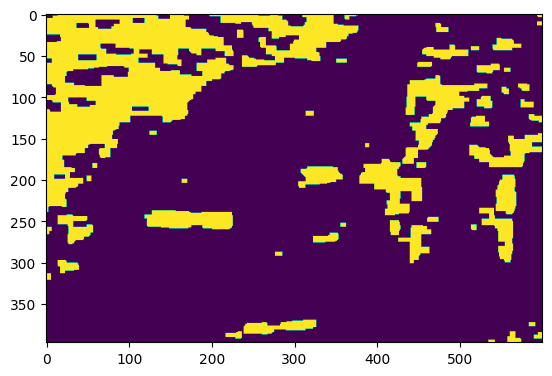

In [31]:
# perform a series of erosions and dilations to clean up the
# thresholded image
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
show_image(thresh)

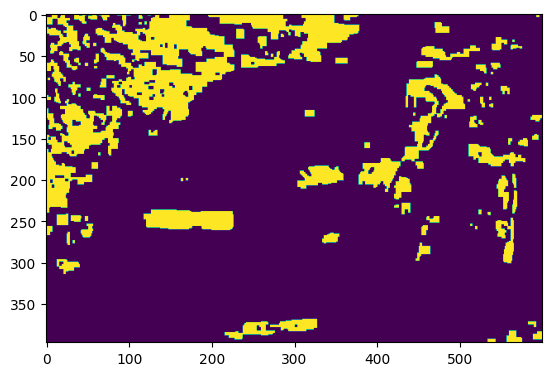

In [32]:
# take the bitwise AND between the threshold result and the
# light regions of the image
thresh = cv2.bitwise_and(thresh, thresh, mask=light)
thresh = cv2.dilate(thresh, None, iterations=2)
thresh = cv2.erode(thresh, None, iterations=1)
show_image(thresh)

In [33]:
# find contours in the thresholded image and sort them by
# their size in descending order, keeping only the largest
# ones
keep=5
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]

In [34]:
minAR=4
maxAR=6
clearBorder=False

# initialize the license plate contour and ROI
lpCnt = None
roi = None
# loop over the license plate candidate contours
for c in cnts:
    # compute the bounding box of the contour and then use
    # the bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    # check to see if the aspect ratio is rectangular
    if ar >= minAR and ar <= maxAR:
        # store the license plate contour and extract the
        # license plate from the grayscale image and then
        # threshold it
        lpCnt = c
        licensePlate = gray[y:y + h, x:x + w]
        roi = cv2.threshold(licensePlate, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # check to see if we should clear any foreground
        # pixels touching the border of the image
        # (which typically, not but always, indicates noise)
        if clearBorder:
            roi = clear_border(roi)
        # display any debugging information and then break
        # from the loop early since we have found the license
        # plate region
        #self.debug_imshow("License Plate", licensePlate)
        #self.debug_imshow("ROI", roi, waitKey=True)
        break

SNSG150



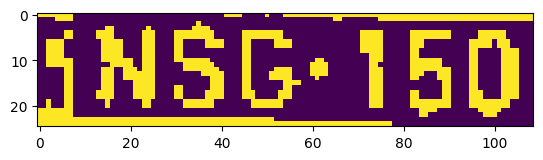

In [39]:

# only OCR the license plate if the license plate ROI is not
# empty
lp = roi
if lp is not None:
    # OCR the license plate
    # tell Tesseract to only OCR alphanumeric characters
    alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    options = "-c tessedit_char_whitelist={}".format(alphanumeric)
    psm = 7
    # set the PSM mode
    options += " --psm {}".format(psm)

    lpText = pytesseract.image_to_string(lp, config=options)
    print(lpText)
    show_image(lp)
    